Note: Before you can run this notebook you must install the required libraries by running `pip install -r requirements.txt`

We first import the needed libraries

In [1]:
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib
import scipy
from itertools import combinations
import matplotlib.pyplot as plt

We then define some methods build the parametric state $ |\psi(\theta) \rangle $ and the random state $ |\phi \rangle $.
We will create a parametric circuit and then we will run it using different values for the parameters. This does not bring a large advantage when using a minimization method, but it really hepls when doing a grid search.
Note: If you're using a version of Qiskit older than 0.13.0 you should use `circ.n_qubits` instead of `circ.num_qubits`

In [2]:
def addLayer(circ, thetas):
    '''
    Adds a layer to the given circuit.
    Parameters:
        circ - the circuit to add the layers to
        thetas - a list of circuit parameters that will hold the rotation angles
    '''
    numQubits = circ.num_qubits
    for i in range(numQubits):
        circ.rz(thetas[i],i)
        
    if numQubits > 1:
        for c, t in combinations(range(numQubits),2):
            circ.cz(c,t)
        
    for i in range(numQubits):
        circ.rx(thetas[i],i)
        
def getCircuit(numQubits, numLayers):
    '''
    Creates a circuit with the given number of qubits and the given number of layers.
    Parameters:
        numQubits - the number of qubits
        numLayers - the number of layers
    Returns: A parameterized circuit.
    '''
    thetas = [[Parameter(f'θ[{i},{j+1}]') for j in range(numQubits)] for i in range(numLayers)]
    thetas = np.array(thetas)
    
    circ = QuantumCircuit(numQubits)
    for i in range(numLayers):
        addLayer(circ, thetas[i])
        circ.barrier()
        
    return circ, thetas
        
def generatePsi(numQubits, numLayers, thetaValues):
    '''
    Generates the state psi(theta).
    Parameters:
        numQubits - the number of qubits
        numLayers - the number of layers
        thetaValues - a matrix of values to replace the parameters.
                      The dimension is [numLayers, numQubits]
                      The line i of the matrix means the value is for the parameter on layer i
                      The column j of the matrix means the value is for the parameter on qubit j
    Returns: a normalized complex vector that represents the state psi
    '''
    circ, parameters = getCircuit(numQubits, numLayers)
    
    parameter_binds={}
    n,m = parameters.shape
    for i in range(n):
        for j in range(m):
            parameter_binds[parameters[i][j]] = thetaValues[i][j]
    
    simulator = Aer.get_backend('statevector_simulator')
    return execute(circ, simulator, parameter_binds=[parameter_binds], shots=1024).result().get_statevector(circ)

def generateRandomState(size):
    '''
    Generates the random state fi.
    Parameters:
       size - the size of the vector 
    Returns: a normalized complex vector that represents the state fi
    '''
    vector = np.random.random(size) + np.random.random(size) * 1j
    norm = np.linalg.norm(vector)
    return vector/norm


Let's check if the function that defines the parametric circuit works well. We'll create a circuit with 4 qubits and 2 layers and we'll draw it.

[[Parameter(θ[0,1]) Parameter(θ[0,2]) Parameter(θ[0,3]) Parameter(θ[0,4])]
 [Parameter(θ[1,1]) Parameter(θ[1,2]) Parameter(θ[1,3]) Parameter(θ[1,4])]]


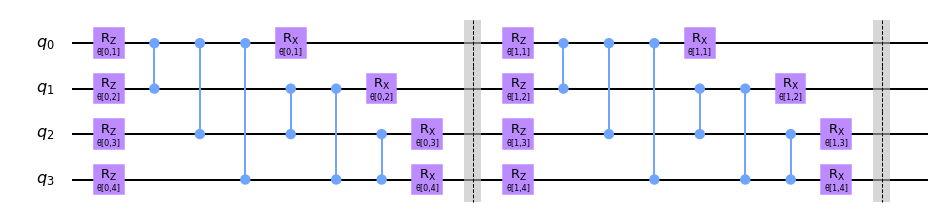

In [3]:
circuit, parameters = getCircuit(4,2)
print(parameters)
circuit.draw(output='mpl')

Let's check that the function that generates the parametric state $ | \psi(\theta) \rangle $ works well. We'll generate a 4-qubit state using some values for the parameters and we'll also check if the norm is 1. 

In [4]:
psi = generatePsi(4,2,[[np.pi, np.pi/2, np.pi/3, np.pi],[np.pi/3, np.pi/4, np.pi, np.pi]])
print(psi)
print(f'Norm of psi: {np.linalg.norm(psi)}')

[ 6.41512031e-02+2.06784001e-01j -3.58160396e-01+1.11113143e-01j
 -9.91691675e-02-7.60951786e-02j  1.31800716e-01-1.71766037e-01j
  1.31800716e-01-1.71766037e-01j  2.97507503e-01+2.28285536e-01j
  1.46283228e-02-3.74714574e-01j  6.49024681e-01+2.53369983e-02j
 -8.00238241e-18-2.14423190e-18j  3.71391860e-18-1.38605329e-17j
  5.17663375e-18-1.93194601e-17j  3.34622866e-17+8.96619266e-18j
  1.73213541e-17+3.00014654e-17j -5.19640623e-17+3.00014654e-17j
  1.24270138e-17-7.17473979e-18j  1.24270138e-17+2.15242194e-17j]
Norm of psi: 1.0


Let's check if the function that generates the random state $ | \phi \rangle $ works well. We'll also check the norm.

In [5]:
fi = generateRandomState(2**4)
print(fi)
print(f'Norm of fi: {np.linalg.norm(fi)}')

[0.23341503+0.03410366j 0.12795674+0.0411998j  0.11828622+0.24026459j
 0.16704901+0.08422726j 0.2534168 +0.29139535j 0.06110514+0.15709925j
 0.28081377+0.01836091j 0.09790086+0.02576281j 0.1250905 +0.30127168j
 0.02439993+0.01720572j 0.25052364+0.07945519j 0.21755954+0.07837532j
 0.21255148+0.0965419j  0.26273812+0.04686688j 0.3084975 +0.2682983j
 0.16672299+0.04524733j]
Norm of fi: 0.9999999999999999


Next we need to define some functions that will help us determine the minimum of the difference vector.

In [6]:
def cost(flattenedThetas, numQubits, numLayers, fi):
    '''
    Computes the norm of the difference vetor.
    Parameters:
        flattenedThetas - the values for the parameters in a one-dimensional array
        numQubits - the number of qubits
        numLayers - the number of layers
        fi - the random state fi
    Returns: The norm of the difference vector
    '''
    thetas = flattenedThetas.reshape(numLayers, numQubits)
    psi = generatePsi(numQubits,numLayers,thetas)
    return np.linalg.norm(psi-fi)

def getMinimum(numQubits, numLayers, fi, numTries, method):
    '''
    Determines the minimum of the cost function.
    Parameters:
        numQubits - the number of qubits
        numLayers - the number of layers
        fi - the random state fi
        numTries - the number of times to repeat the minimum estimation
        method - the method used to determine the minimum
    Returns: the minimum of the cost function
    '''
    def oneTry():
        start = np.random.uniform(low=0, high=2*np.pi, size=(numQubits*numLayers,))
        res = scipy.optimize.minimize(cost, start,(numQubits, numLayers, fi), method=method)
        return res.fun
    
    minim=oneTry()
    
    tries=1
    while tries<numTries:
        res = oneTry()
        if minim > res:
            minim = res
        tries += 1
    return minim

def doExperiments(qubitCounts, layerCounts, numTries, method):
    '''
    Finds the minimum of the difference norm for different number of qubits and different numbers of layers.
    Parameters:
        qubitCounts - an array containing different qubit counts
        numLayers - an array containing different number of layers
        fi - the random state fi
        numTries - the number of times to repeat the minimum estimation
        method - the method used to determine the minimum
    Returns: an dictionary where the keys are the different qubit counts 
             and the valus are arrays containing the minimum found for each layer count 
    '''
    results = {}
    for numQubits in qubitCounts:
        fi = generateRandomState(2**numQubits)

        label = f'{numQubits} Qubits'
        results[label] = np.zeros(len(layerCounts))
        for i, numLayers in enumerate(layerCounts):
            results[label][i] = getMinimum(numQubits, numLayers, fi, numTries, method)

    return results

We now need a function to plot the results

In [7]:
def plot(results, layerCounts):
    '''
    Plots the results.
    Parameters:
        reults - the output of the `doExperiments` method
        layerCounts - an array containing different number of layers used
    '''
    for key in results.keys():
        y = results[key]
        plt.plot(layerCounts, y, '-*', label=key)

    plt.xlabel('Number of layers')
    plt.ylabel('Minimum difference')
    plt.title('The mimimum between psi and fi')
    plt.legend()
    plt.show()

Now it's time to run the experiments and look at the results. Depending on the number of qubits, number of tries and the number of layers this can take a long time.

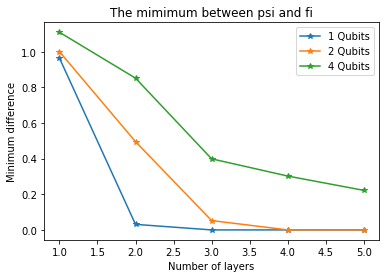

In [8]:
qubitCounts = [1,2,4]
layerCounts = [1,2,3,4,5]
numTries = 3
method = 'COBYLA' #or 'Nelder-Mead'

results = doExperiments(qubitCounts, layerCounts, numTries, method)
plot(results, layerCounts)

In [9]:
results

{'1 Qubits': array([9.64540675e-01, 3.11280866e-02, 4.08310029e-05, 8.55058814e-05,
        8.44477567e-05]),
 '2 Qubits': array([1.00067479e+00, 4.95200749e-01, 5.25063600e-02, 1.76169435e-04,
        1.03313014e-04]),
 '4 Qubits': array([1.10918507, 0.8516785 , 0.39898075, 0.30234863, 0.2219896 ])}

If you would like to use different rotation types you must modify the `addLayer` function and change the gate types. For example replace the `rx` gates with `ry` gates; or replace the `cz` gates with `cx` gates. But from my experience the results will be similar